In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def cart2sph(cart):
	xy2 = cart[:,0]**2 + cart[:,1]**2
	sph = np.zeros_like(cart)
	sph[:,0] = np.sqrt(xy2 + cart[:,2]**2)
	sph[:,1] = np.arctan2(np.sqrt(xy2), cart[:,2]) # Elevation angle defined from Z-axis down
	sph[:,2] = np.arctan2(cart[:,1], cart[:,0])
	return sph

In [5]:
def block_doa(frm_val, block_size):
    n_blocks = frm_val.shape[1]// block_size + 1

    blk_doas = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):

        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + frm_val.shape[1]

        blk_sum = torch.sum(frm_val[:,blk_start:blk_end],dim=1)
        blk_doa_idx = torch.argmax(blk_sum)
        blk_doa = blk_doa_idx

        blk_start = blk_end

        blk_doas.append(blk_doa)

    return blk_doas

#for now taking absolute inside the block
def block_lbl_doa(lbl_doa, block_size):
    #assuming lbl_doa [r, elv, azi] : (1, frms, 3)
    n_blocks = lbl_doa.shape[1]// block_size + 1

    blk_doas = []
    blk_range = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):
        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + lbl_doa.shape[1]

        blk_doa = torch.mean(torch.abs(lbl_doa[:,blk_start:blk_end, : ]),dim=1)

        blk_start = blk_end
        blk_doas.append(torch.rad2deg(blk_doa[:,2])) # azimuth
        blk_range.append(blk_doa[:,0]) # range

    return blk_doas, blk_range


def blk_vad(frm_level_vad, block_size):
    #assuming frm_level_vad : (frms)
    n_blocks = frm_level_vad.shape[0]// block_size + 1

    frm_level_vad = 1.0*frm_level_vad
    blk_vads = []
    blk_start = 0
    for blk_idx in range(0, n_blocks):
        if blk_idx < n_blocks-1:
            blk_end = blk_start + block_size
        else:
            blk_end = blk_start + frm_level_vad.shape[0]

        _blk_vad = torch.mean(frm_level_vad[blk_start:blk_end])

        blk_start = blk_end
        blk_vads.append(_blk_vad)
    return blk_vads


In [6]:
tol = 5

def get_acc(est_vad, est_blk_val, tgt_blk_val, tol=5, vad_th=0.6):
    n_blocks = len(est_vad)
    non_vad_blks =[]
    acc=0
    valid_blk_count = 0
    for idx in range(0, n_blocks):
        if est_vad[idx] >=vad_th:
            if (np.abs(est_blk_val[idx] - np.abs(tgt_blk_val[idx])) <= tol):
                acc += 1
            valid_blk_count +=1
        else:
            non_vad_blks.append(idx)

    acc /= valid_blk_count
    
    #print(f'n_blocks: {n_blocks}, non_vad_blks: {non_vad_blks}')
    return acc



In [5]:
scenario = "source_moving"
snr =  -5
t60 = 0.2
src_mic_dist = 1.0
noi_mic_dist = 1.0

idx=0
#read the config file
#
scratch_dir='/scratch/bbje/battula12/ControlledExp/Testing/Scenario_Comparision/'
file_path = f'../val_dataset_file_circular_motion_snr_{snr}_t60_{t60}.txt' #dataset_file_10sec.txt'

with open(file_path) as f:
    configs_lst = [line.strip().split(',')[-1] for line in f.readlines()]


config_file = configs_lst[idx]

cfg = torch.load(config_file)

config_dict = cfg #circular_motion_config_dict
room_sz = config_dict['room_sz']
mic_pos = config_dict['mic_pos']
traj_pts= config_dict['src_traj_pts']
noise_pos= config_dict['noise_pos']
T60= config_dict['t60']
SNR= config_dict['snr']

noise_pos =  np.expand_dims(noise_pos, axis=0) if len(noise_pos.shape) == 1 else noise_pos


array_pos = np.mean(mic_pos, axis=0, keepdims=True)
noise_spherical = cart2sph(noise_pos-array_pos)

#range motion of source
print(f' Noise range: {noise_spherical[:,0]}, elevation: {np.degrees(noise_spherical[:,1])}, azimuth : {np.degrees(noise_spherical[:,2]) }')


mix_t60_lst = []
est_t60_lst = []
mvng_t60_lst = []

mix_frm_t60_lst = []
est_frm_t60_lst = []
mvng_frm_t60_lst = []

for t60 in [0.2]:
    mix_avg_lst = []
    est_avg_lst = []
    mvng_avg_lst = []

    mix_metric_avg_lst = []
    est_metric_avg_lst = []
    mvng_est_metric_avg_lst = []
    
    mix_frm_avg_lst = []
    est_frm_avg_lst = []
    mvng_frm_avg_lst = []
    pp_str = f'{scratch_dir}signals/{scenario}/from_val_dataset_circular_motion_snr_{snr}_t60_{t60}_src_mic_dist_{src_mic_dist}_noi_mic_dist_{noi_mic_dist}/'  #from_dataset_file_10sec/v2/'
    for batch_idx in range(0, 640): #idx, idx+1
        app_str = f'{batch_idx}'

        #app_str = f'sp_{static_prob}_nlp_{non_linear_motion_prob}_snr_{test_snr}_t60_{test_t60}_nb_points_{nb_points}'

        info = torch.load(f'{pp_str}doa_{app_str}.pt')

        #### 
        mix_metrics = info['mix_metrics']
        est_metrics = info['est_metrics']
        mvng_est_metrics = info['mvng_est_metrics']

        est_metrics = list(est_metrics.values())
        mix_metrics = list(mix_metrics.values())
        mvng_est_metrics = list(mvng_est_metrics.values())

        
        est_metric_avg_lst.append(est_metrics)
        mix_metric_avg_lst.append(mix_metrics)
        mvng_est_metric_avg_lst.append(mvng_est_metrics)



        (mix_f_doa, mix_f_vals, mix_sig_vad, mix_utt_doa, mix_utt_sum) = info['mix']
        (tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, tgt_utt_sum) = info['tgt']
        (est_f_doa, est_f_vals, est_sig_vad, est_utt_doa, est_utt_sum) = info['est']
        (mvng_est_f_doa, mvng_est_f_vals, mvng_est_sig_vad, mvng_est_utt_doa, mvng_est_utt_sum) = info['mvng_est']
        lbl_doa = info['lbl_doa']


        mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(tgt_f_doa),vad_th=0.6)
        est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(tgt_f_doa),vad_th=0.6)
        mvng_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mvng_est_f_doa), np.array(tgt_f_doa),vad_th=0.6)


        mix_frm_avg_lst.append(mix_frm_Acc)
        est_frm_avg_lst.append(est_frm_Acc)
        mvng_frm_avg_lst.append(mvng_frm_Acc)
        

        blk_size = 25
        mix_blk_vals = block_doa(frm_val=mix_f_vals, block_size=blk_size)
        tgt_blk_vals = block_doa(frm_val=tgt_f_vals, block_size=blk_size)
        est_blk_vals = block_doa(frm_val=est_f_vals, block_size=blk_size)
        mvng_est_blk_vals = block_doa(frm_val=mvng_est_f_vals, block_size=blk_size)

        lbl_blk_doa, lbl_blk_range = block_lbl_doa(lbl_doa, block_size=blk_size)

        mix_blk_vad = blk_vad(mix_sig_vad, blk_size)
        tgt_blk_vad = blk_vad(tgt_sig_vad, blk_size)
        est_blk_vad = blk_vad(est_sig_vad, blk_size)
        mvng_blk_vad = blk_vad(mvng_est_sig_vad, blk_size)

        mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
        est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))
        mvng_est_Acc = get_acc(np.array(tgt_blk_vad), np.array(mvng_est_blk_vals), np.array(tgt_blk_vals))

        mix_avg_lst.append(mix_Acc)
        est_avg_lst.append(est_Acc)
        mvng_avg_lst.append(mvng_est_Acc)

    mvng_est_avg_metrics = np.array(mvng_est_metric_avg_lst)
    est_avg_metrics = np.array(est_metric_avg_lst)
    mix_avg_metrics = np.array(mix_metric_avg_lst)

    mvng_est_Avg = np.mean(mvng_est_avg_metrics, axis=0)
    est_Avg = np.mean(est_avg_metrics, axis=0)
    mix_Avg = np.mean(mix_avg_metrics, axis=0)

    mix_t60_lst.append(np.mean(np.array(mix_avg_lst)))
    est_t60_lst.append(np.mean(np.array(est_avg_lst)))
    mvng_t60_lst.append(np.mean(np.array(mvng_avg_lst)))

    
    mix_frm_t60_lst.append(np.mean(np.array(mix_frm_avg_lst)))
    est_frm_t60_lst.append(np.mean(np.array(est_frm_avg_lst)))
    mvng_frm_t60_lst.append(np.mean(np.array(mvng_frm_avg_lst)))

 Noise range: [1.], elevation: [90.], azimuth : [-178.]


In [6]:
mix_Acc, est_Acc, mvng_est_Acc, mix_frm_Acc, est_frm_Acc, mvng_frm_Acc

(0.3333333333333333,
 0.5,
 0.5833333333333334,
 0.24299065420560748,
 0.2803738317757009,
 0.3395638629283489)

In [7]:
mix_Avg, est_Avg, mvng_est_Avg

(array([-6.00681323, -6.03550759,  1.41079591,  1.0577853 ,  0.60732904,
         0.35587946]),
 array([6.38475613, 5.36693531, 2.30170005, 1.39591886, 0.82569725,
        0.65783662]),
 array([6.35395166, 5.36960058, 2.30795499, 1.39779006, 0.82565282,
        0.65779185]))

In [8]:
info['mix_metrics'], info['est_metrics'], info['mvng_est_metrics']

({'snr': -6.00355771162421,
  'si_snr': -5.658256979307592,
  'pesq_nb': 1.2158073126084024,
  'pesq_wb': 1.0328297563409783,
  'stoi': 0.5078695358747172,
  'e_stoi': 0.20249734583532839},
 {'snr': 5.754544110135666,
  'si_snr': 4.5878636607612435,
  'pesq_nb': 2.2900872116025424,
  'pesq_wb': 1.3968142797247605,
  'stoi': 0.7764130517115503,
  'e_stoi': 0.549517355485822},
 {'snr': 5.818127364631898,
  'si_snr': 4.688763147990587,
  'pesq_nb': 2.22408508142413,
  'pesq_wb': 1.3954157759513879,
  'stoi': 0.7654671870377318,
  'e_stoi': 0.5341782637905006})

In [9]:
src_azimuth = np.degrees(cart2sph(traj_pts-array_pos)[:,2])
src_azimuth_keys = np.round(np.where(src_azimuth<0, 360+src_azimuth, src_azimuth)).astype('int32')	

In [10]:
src_azimuth, src_azimuth_keys, src_azimuth_keys-180

(array([-163., -151., -139., -128., -116., -104.,  -92.,  -80.,  -69.,
         -57.,  -45.,  -33.,  -21.,  -10.,    2.,   14.]),
 array([197, 209, 221, 232, 244, 256, 268, 280, 291, 303, 315, 327, 339,
        350,   2,  14], dtype=int32),
 array([  17,   29,   41,   52,   64,   76,   88,  100,  111,  123,  135,
         147,  159,  170, -178, -166], dtype=int32))

In [11]:
mvng_est_blk_vals, est_blk_vals

([tensor(70),
  tensor(98),
  tensor(110),
  tensor(104),
  tensor(88),
  tensor(93),
  tensor(81),
  tensor(77),
  tensor(72),
  tensor(69),
  tensor(64),
  tensor(64),
  tensor(57),
  tensor(70),
  tensor(0),
  tensor(35)],
 [tensor(71),
  tensor(92),
  tensor(109),
  tensor(103),
  tensor(88),
  tensor(92),
  tensor(80),
  tensor(75),
  tensor(71),
  tensor(66),
  tensor(64),
  tensor(64),
  tensor(57),
  tensor(0),
  tensor(0),
  tensor(35)])

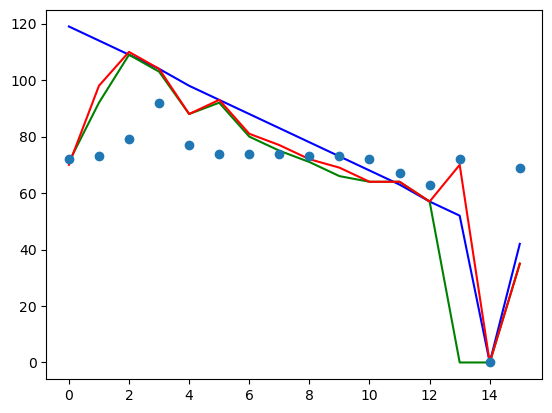

In [12]:
plt.figure()
plt.plot(tgt_blk_vals,'b')
plt.plot(est_blk_vals,'g')
plt.plot(mvng_est_blk_vals,'r')
plt.plot(mix_blk_vals, 'o')
#plt.plot(src_azimuth, 'b+')

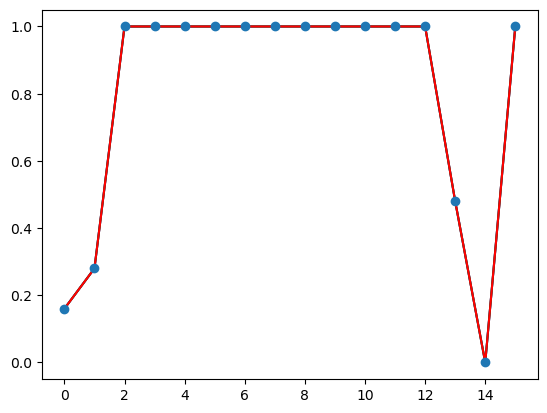

In [13]:
plt.figure()
plt.plot(tgt_blk_vad,'b')
plt.plot(est_blk_vad,'g')
plt.plot(mvng_blk_vad,'r')
plt.plot(mix_blk_vad, 'o')

In [14]:
np.array(tgt_blk_vals)-np.array(mvng_est_blk_vals), np.array(tgt_blk_vals)-np.array(est_blk_vals)

(array([ 49,  16,  -1,   0,  10,   0,   7,   6,   6,   4,   4,  -1,   0,
        -18,   0,   7]),
 array([48, 22,  0,  1, 10,  1,  8,  8,  7,  7,  4, -1,  0, 52,  0,  7]))

In [11]:
#Rigorours doa analysis 
import torch
import numpy as np
batch_idx = 2

dataset_condition = "reverb"
dataset_dtype = "stationary"
app_str = f'{batch_idx}'
t60=1

info =torch.load(f'../signals/tr_s_test_{dataset_dtype}_{dataset_condition}_{t60}doa_{app_str}.pt')

(mix_f_doa, mix_f_vals, mix_sig_vad, mix_utt_doa, mix_utt_sum) = info['mix']
(tgt_f_doa, tgt_f_vals, tgt_sig_vad, tgt_utt_doa, tgt_utt_sum) = info['tgt']
(est_f_doa, est_f_vals, est_sig_vad, est_utt_doa, est_utt_sum) = info['est']

mix_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(mix_f_doa), np.array(tgt_f_doa),tol = 5, vad_th=0.6)
est_frm_Acc = get_acc(np.array(tgt_sig_vad), np.array(est_f_doa), np.array(tgt_f_doa),tol = 5, vad_th=0.6)


blk_size = 25
mix_blk_vals = block_doa(frm_val=mix_f_vals, block_size=blk_size)
tgt_blk_vals = block_doa(frm_val=tgt_f_vals, block_size=blk_size)
est_blk_vals = block_doa(frm_val=est_f_vals, block_size=blk_size)

#lbl_blk_doa, lbl_blk_range = block_lbl_doa(lbl_doa, block_size=blk_size)
tgt_blk_vad = blk_vad(tgt_sig_vad, blk_size)

mix_Acc = get_acc(np.array(tgt_blk_vad), np.array(mix_blk_vals), np.array(tgt_blk_vals))
est_Acc = get_acc(np.array(tgt_blk_vad), np.array(est_blk_vals), np.array(tgt_blk_vals))


print(dataset_dtype, mix_frm_Acc, est_frm_Acc, mix_Acc, est_Acc)

stationary 0.4192708333333333 0.4973958333333333 0.875 0.8125


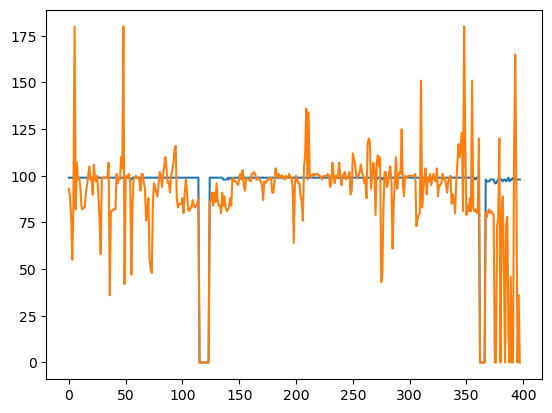

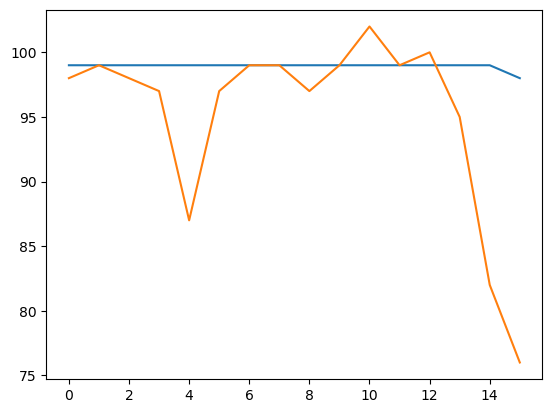

In [12]:
plt.plot(tgt_f_doa)
plt.plot(est_f_doa)

plt.figure()
plt.plot(tgt_blk_vals)
plt.plot(est_blk_vals)

In [4]:
import torch

x = torch.rand(2,2)
x.device

device(type='cpu')